# Convolutional Neural Network

##### Digit Recognition on MNIST dataset

Convolutional Neural Networks are are a special kind of multi-layer neural networks. Like almost every other neural networks they are trained with a version of the back-propagation algorithm. Where they differ is in the architecture.
Convolutional Neural Networks are designed to recognize visual patterns directly from pixel images with minimal preprocessing.
They can recognize patterns with extreme variability (such as handwritten characters), and with robustness to distortions and simple geometric transformations.

##### Network architecture

##### <span style="color:orange">Conv->Pool->Conv->Pool->Dense->Dense</span>

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Read dataset

In [3]:
import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [4]:
train = pd.read_csv('../input/train.csv')

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train.shape

(42000, 785)

## Preprocessing

In [7]:
data_X = train.drop('label', axis=1).values
data_Y = train['label'].values

In [8]:
data_Y = np.eye(10)[data_Y]     #one hot encoding

data_X = data_X/255.0             #normalization
data_X = data_X.reshape(-1, 28, 28, 1)

In [9]:
print('Shape of data_X : ', data_X.shape)
print('Shape of data_Y : ', data_Y.shape)

Shape of data_X :  (42000, 28, 28, 1)
Shape of data_Y :  (42000, 10)


In [10]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_X, data_Y, test_size = 0.33)

In [11]:
print('Shape of train_x \t: ', train_x.shape)
print('Shape of train_y \t: ', train_y.shape)
print('Shape of test_x  \t: ', test_x.shape)
print('Shape of test_y  \t: ', test_y.shape)

Shape of train_x 	:  (28140, 28, 28, 1)
Shape of train_y 	:  (28140, 10)
Shape of test_x  	:  (13860, 28, 28, 1)
Shape of test_y  	:  (13860, 10)


## Helper Functions


In [12]:
# Outputs a batch of data
def next_batch(batch_size, x, y):
    
    idx = np.arange(0, len(x))
    np.random.shuffle(idx)
    
    idx = idx[: batch_size]
    
    x = [x[i] for i in idx]
    y = [y[i] for i in idx]
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [13]:
# Display 10 random images
def display_images(data, title, display_label = True):
    x, y = data
    x = x.reshape(-1, 28, 28)
    y = np.argmax(y, axis=1)
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    fig.subplots_adjust(hspace = 0.7, wspace = 0.7)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i], cmap='gray')
        if display_label:
            ax.set_xlabel(y[i], fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


In [14]:
# wrapper function for convolution layer
def conv2d(x, w, b, strides = 1, padding = 'SAME'):
    x = tf.nn.conv2d(x, w, strides = [1, strides, strides, 1], padding = padding)
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x

In [15]:
# wrapper function for pooling layer
def maxpool2d(x, k = 2, padding = 'SAME'):
    x = tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = padding)
    return x 

In [16]:
# wrapper function for fully connected layer
def dense(x, w, b, activation = 'none'):
    x = tf.matmul(x, w)
    x = tf.nn.bias_add(x, b)
    if activation == 'relu':
        x = tf.nn.relu(x)  
    return x

## Visualization

Display 10 random images and their labels from the training data

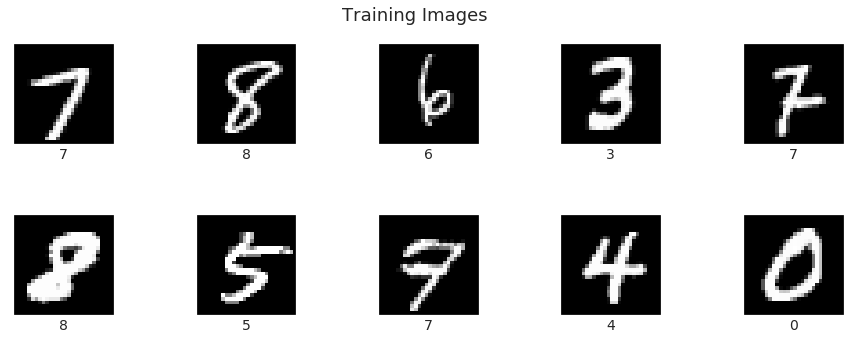

In [17]:
display_images(next_batch(10, train_x, train_y), 'Training Images')

## Model

In [18]:
# training hyperparameters
learning_rate = 0.001
epochs = 10000
batch_size = 128

In [19]:
# image dimensions and number of classes
image_width = 28
image_height = 28
color_channels = 1
n_classes = 10

In [20]:
# placeholders
X = tf.placeholder(tf.float32, shape = [None, image_width, image_height, color_channels]) 
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) 

In [21]:
# parameters
weights = { 'w1' : tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1)),
            'w2' : tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1)),
            'w3' : tf.Variable(tf.truncated_normal([7*7*64,1024], stddev=0.1)),
            'w4' : tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1)) }

biases = {  'b1' : tf.constant(0.1 ,shape=[32]),
            'b2' : tf.constant(0.1 ,shape=[64]),
            'b3' : tf.constant(0.1 ,shape=[1024]),
            'b4' : tf.constant(0.1 ,shape=[10]) }

In [22]:
def ConvNet(x, weight, bias):
     # Layer 1 : Convolution : input (28x28x1); output (28x28x32)
    conv1 = conv2d(x, weight['w1'], bias['b1'])
    # Layer 2 : Sub sampling : input (28x28x32); outpute (14x14x32)
    pool1 = maxpool2d(conv1) 
    # Layer 3 : Convolution : input (14x14x32); output (14x14x64)
    conv2 = conv2d(pool1, weight['w2'], bias['b2'])
    # Layer 4: Sub sampling : input (14x14x64); output (7x7x64)
    pool2 = maxpool2d(conv2) 
    # Flatten the 2-d image to a 1-d vector : input (7x7x64); output (3136)
    flat = tf.reshape(pool2, [-1, weights['w3'].get_shape().as_list()[0]])
    # Layer 5: Fully Connected : input (3136); output (1024)
    fc1 = dense(flat, weight['w3'], bias['b3'], 'relu')
    # Layer 6: Fully Connected : input (1024); output (10)
    logits = dense(fc1, weight['w4'], bias['b4'], 'none') 
    
    return logits

In [23]:
# model output
logits = ConvNet(X, weights, biases)
# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
# minimize loss
train = optimizer.minimize(loss)

In [24]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [25]:
init = tf.global_variables_initializer()

## Train

In [26]:
with tf.Session() as sess:
    
    sess.run(init)
    
    cost_hist, acc_hist = [], []
    
    for epoch in range(1, epochs + 1):
        
        batch_x, batch_y = next_batch(batch_size, train_x, train_y)
        
        sess.run(train, feed_dict = { X : batch_x, Y : batch_y})
    
        if epoch % 500 == 0:
            c, acc = sess.run([loss, accuracy], feed_dict = { X : batch_x, Y : batch_y})
            cost_hist.append(c)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(c) + ', Accuracy: ' + str(acc))

    print('-' * 70)
    print('\nOptimization Finished\n')
    print('Accuracy on train data \t: ' + str(sess.run(accuracy, feed_dict = { X : train_x, Y :train_y}) * 100) + ' %')
    print('Accuracy on test data  \t: ' + str(sess.run(accuracy, feed_dict = { X : test_x, Y : test_y}) * 100) + ' %')

Epoch 500, Cost: 0.109709665, Accuracy: 0.96875
Epoch 1000, Cost: 0.006271188, Accuracy: 1.0
Epoch 1500, Cost: 0.0028693937, Accuracy: 1.0
Epoch 2000, Cost: 0.008688201, Accuracy: 0.9921875
Epoch 2500, Cost: 0.0010951553, Accuracy: 1.0
Epoch 3000, Cost: 0.00079769385, Accuracy: 1.0
Epoch 3500, Cost: 0.00043886036, Accuracy: 1.0
Epoch 4000, Cost: 0.0010493284, Accuracy: 1.0
Epoch 4500, Cost: 0.00046953777, Accuracy: 1.0
Epoch 5000, Cost: 0.00065154134, Accuracy: 1.0
Epoch 5500, Cost: 0.0005224369, Accuracy: 1.0
Epoch 6000, Cost: 0.00034485242, Accuracy: 1.0
Epoch 6500, Cost: 0.0009569601, Accuracy: 1.0
Epoch 7000, Cost: 0.00011419409, Accuracy: 1.0
Epoch 7500, Cost: 7.714563e-05, Accuracy: 1.0
Epoch 8000, Cost: 1.2490909e-05, Accuracy: 1.0
Epoch 8500, Cost: 4.4237072e-07, Accuracy: 1.0
Epoch 9000, Cost: 1.1206437e-05, Accuracy: 1.0
Epoch 9500, Cost: 0.00015300624, Accuracy: 1.0
Epoch 10000, Cost: 0.00017225562, Accuracy: 1.0
--------------------------------------------------------------

## Change in cost function

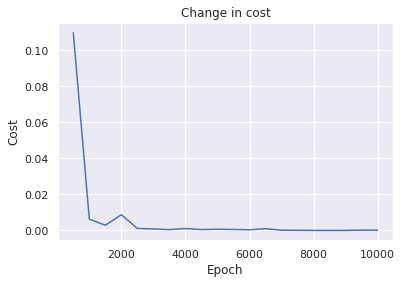

In [27]:
eps = list(range(500, epoch+500, 500))
plt.plot(eps, cost_hist)
plt.title("Change in cost")
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

## Change in accuracy

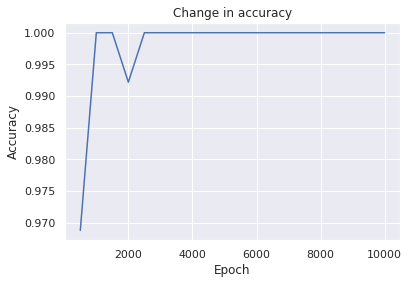

In [28]:
eps = list(range(500, epoch+500, 500))
plt.plot(eps, acc_hist)
plt.title("Change in accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Validate

In [29]:
# KFold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5)

current_fold = 1

train_acc_hist = []
test_acc_hist = []

for train_index, test_index in kf.split(data_Y):
     
    KFold_X_train = data_X[list(train_index)]
    KFold_X_test = data_X[test_index]
    KFold_Y_train = data_Y[train_index]
    KFold_Y_test = data_Y[test_index]

    # run the graph
    with tf.Session() as sess:
    
        sess.run(init)

        for epoch in range(1, epochs + 1):

            batch_x, batch_y = next_batch(batch_size, KFold_X_train, KFold_Y_train)

            sess.run(train, feed_dict = { X : batch_x, Y : batch_y })
    
        train_accuracy = sess.run(accuracy, feed_dict = { X : KFold_X_train, Y :KFold_Y_train }) * 100
        test_accuracy = sess.run(accuracy, feed_dict = { X : KFold_X_test, Y : KFold_Y_test }) * 100
        
        train_acc_hist.append(train_accuracy)
        test_acc_hist.append(test_accuracy)

        print('\nFOLD-' + str(current_fold) + '\n')
        print('Accuracy on train data \t:  {0:.2f} %'.format(train_accuracy))
        print('Accuracy on test data  \t:  {0:.2f} %'.format(test_accuracy))
        
        
        W = sess.run(weights)
        B = sess.run(biases)
    

    current_fold = current_fold +1
    
train_cross_val_score = np.mean(train_acc_hist)    
test_cross_val_score = np.mean(test_acc_hist)

print('-' * 70)
print('\nOPTIMIZATION FINISHED\n')
print('\n\nFINAL TRAIN SET K-FOLD CROSS VALIDATION ACCURACY \t:  {0:.2f}'.format(train_cross_val_score))
print('\nFINAL TEST SET K-FOLD CROSS VALIDATION ACCURACY    \t:  {0:.2f}'.format(test_cross_val_score))


FOLD-1

Accuracy on train data 	:  99.94 %
Accuracy on test data  	:  98.70 %

FOLD-2

Accuracy on train data 	:  100.00 %
Accuracy on test data  	:  99.13 %

FOLD-3

Accuracy on train data 	:  99.81 %
Accuracy on test data  	:  98.55 %

FOLD-4

Accuracy on train data 	:  99.87 %
Accuracy on test data  	:  98.96 %

FOLD-5

Accuracy on train data 	:  99.99 %
Accuracy on test data  	:  99.18 %
----------------------------------------------------------------------

OPTIMIZATION FINISHED



FINAL TRAIN SET K-FOLD CROSS VALIDATION ACCURACY 	:  99.92

FINAL TEST SET K-FOLD CROSS VALIDATION ACCURACY    	:  98.90


## Save the parameters of the model

In [30]:
for key in W.keys():
    np.save(key, W[key])
for key in B.keys():
    np.save(key, B[key])

## Predict

In [31]:
# load the prediction dataset
test = pd.read_csv('../input/test.csv')

# preprocess the prediction dataset 
data_X = test.values
data_X = data_X.reshape(-1, 28, 28, 1)     # reshape
data_X = data_X/255.0     # normalize

In [32]:
# set the parameters to the learned parameters
for key in weights.keys():
    weights[key] = tf.Variable(W[key])
for key in biases.keys():
    biases[key] = tf.Variable(B[key])

In [33]:
logits = ConvNet(X, weights, biases)

In [34]:
with tf.Session() as sess:
    
    for key in weights.keys():
        sess.run(weights[key].initializer)
    for key in biases.keys():
        sess.run(biases[key].initializer)
    
    output = sess.run(logits, feed_dict= {X : data_X}) 

## Visualization

Display the images and their labels as predicted by the ConvNet

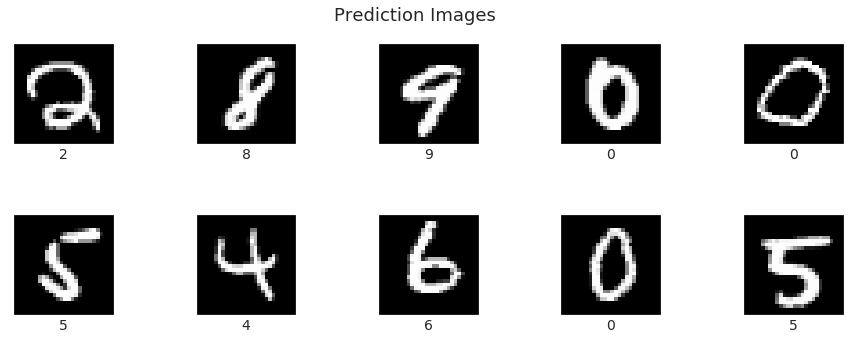

In [35]:
display_images(next_batch(10, data_X, output), 'Prediction Images')

In [36]:
predictions = np.argmax(output, axis=1)

## Kaggle Submission

Code to make the submission file for kaggle

In [37]:
index = test.index +1 

ImageId = list(index)
Label = list(predictions)

df = pd.DataFrame([ImageId ,Label])
df = df.T
df.columns = [['ImageId', 'Label']]

df.to_csv('submission.csv', index=False)